This notebook contains advanced rendering function, please use jupyter nbviewer

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from collections import Counter
import datetime as dt
import pickle


client = Client(processes=False)
df = dd.read_csv("../data/raw/Eluvio_DS_Challenge.csv", blocksize=64000000)
df.time_created = df.time_created.astype('uint32')
df.up_votes = df.up_votes.astype('uint16')
df.down_votes = df.down_votes.astype('uint16')
df["date_created"] = df["date_created"].map_partitions(pd.to_datetime, format='%Y/%m/%d', meta=('datetime64[ns]'))
#df.index = df['date_created']
#df['year'] = df.index.dt.year

df = client.persist(df)
print df.dtypes;
MODEL_TYPES = {
    'LDA': LatentDirichletAllocation,
    'LSA': TruncatedSVD
}
TOPIC_COLOR_MAP = np.array([
    "#1f77b5", "#aec7e9", "#ff7f0f", "#ffbb79", "#2ca02d", "#98df8b", "#d62729", "#ff9897", "#9467be", "#c5b0d6",
    "#8c564c", "#c49c95", "#e377c3", "#f7b6d3", "#7f7f80", "#c7c7c8", "#bcbd23", "#dbdb8e", "#17bed0", "#9edae6"
])
count_vectorizer_limited = CountVectorizer(stop_words='english', max_features=40000)

def keys_to_counts(keys):
        count_pairs = Counter(keys).items()
        categories = [pair[0] for pair in count_pairs]
        counts = [pair[1] for pair in count_pairs]
        return (categories, counts)
    
def get_keys(topic_matrix):
        keys = topic_matrix.argmax(axis=1).tolist()
        return keys
    
def get_top_n_words(n, n_topics, document_term_matrix, keys, count_vectorizer):
        top_word_indices = []
        for topic in range(n_topics):
            temp_vector_sum = 0
            for i in range(len(keys)):
                if keys[i] == topic:
                    temp_vector_sum += document_term_matrix[i]
            temp_vector_sum = temp_vector_sum.toarray()
            top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
            top_word_indices.append(top_n_word_indices)   
        top_words = []
        for topic in top_word_indices:
            topic_words = []
            for index in topic:
                temp_word_vector = np.zeros((1, document_term_matrix.shape[1]))
                temp_word_vector[:,index] = 1
                the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
                topic_words.append(the_word.encode('ascii').decode('utf-8'))
            top_words.append(" ".join(topic_words)) 
        return top_words

class Topic_Model:
    def __init__(self, input_df, model_type='LDA',max_features=None, sample_rate=0.05, **args):
        self.df = input_df
        self.sample_rate = sample_rate
        self.n_components = args['n_components'] if 'n_components' in args else 0
        self.sampled_df = self.df.sample(frac=sample_rate)
        self.sampled_titles = self.sampled_df['title'].compute().values
        self.sampled_up_votes = self.sampled_df['up_votes'].compute().values
        self.sampled_document_term_matrix = count_vectorizer_limited.fit_transform(self.sampled_titles)
        
        self.model_type = model_type
        if model_type.upper() not in MODEL_TYPES.keys():
            self.model_type = MODEL_TYPES.keys()[0]
        model_func = MODEL_TYPES[self.model_type]
        print "initialing & fitting {} model...".format(self.model_type)
        self.model = model_func(**args)
        self.topic_matrix = self.model.fit_transform(self.sampled_document_term_matrix)
        
        self.keys = get_keys(self.topic_matrix)
        self.categories, self.counts = keys_to_counts(self.keys)
        model_filename = "../models/{}_with_sr_{}.model".format(self.model_type, self.sample_rate)
        with open(model_filename,'wb') as f:
            pickle.dump(self.model, f)
        print "Model initialization done. Model saved to disk."
    
    def get_top_n_topics(self, count_vectorizer, n=10):
        top_n_words = get_top_n_words(n, self.n_components, self.sampled_document_term_matrix, self.keys, count_vectorizer)
        print "top {} words for each topic by {}:".format(n, self.model_type)
        for idx, topic in enumerate(top_n_words):
            print("Topic {}: ".format(idx + 1), topic)

    
    def plot_num_title_of_each_topic(self, count_vectorizer):
        top_3_words = get_top_n_words(3, self.n_components, self.sampled_document_term_matrix, self.keys, count_vectorizer)
        print "self.categories:{}".format(self.categories)
        print "top_3_words:{}".format(top_3_words)
        labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in self.categories]
        fig, ax = plt.subplots(figsize=(16,8))
        print "Frequency of the {} topics by {}:".format(self.n_components, self.model_type)
        ax.bar(self.categories, self.counts)
        ax.set_xticks(self.categories)
        plt.xticks(rotation=45)
        ax.set_xticklabels(labels)
        ax.set_ylabel('Number of titles')
        ax.set_title('{} topic frequency'.format(self.model_type))
        plt.show()
        
    def _get_mean_topic_vectors(self, keys, two_dim_vectors):
        '''
        returns a list of centroid vectors from each predicted topic category
        '''
        centroid_topic_vectors = []
        for t in range(self.n_components):
            articles_in_that_topic = []
            for i in range(len(keys)):
                if keys[i] == t:
                    articles_in_that_topic.append(two_dim_vectors[i])    

            articles_in_that_topic = np.vstack(articles_in_that_topic)
            centroid_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
            centroid_topic_vectors.append(centroid_article_in_that_topic)
        return centroid_topic_vectors
    
    def visualize_tnse_2_dimension(self, count_vectorizer):
        print "use t-SNE to visualize {} high dimensional dataset".format(self.model_type)
        tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=0, random_state=0, angle=0.75)
        tsne_vectors = tsne_model.fit_transform(self.topic_matrix)
        mean_topic_vectors = self._get_mean_topic_vectors(self.keys, tsne_vectors)
        
        colormap = TOPIC_COLOR_MAP[:self.n_components]
        proportion = 20;
        sampled_up_votes_sizes = self.sampled_up_votes / proportion;
        top_3_words = get_top_n_words(3, self.n_components, self.sampled_document_term_matrix, self.keys, count_vectorizer)
        fig, ax = plt.subplots(figsize=(16,16))
        plt.scatter(x=tsne_vectors[:,0], y=tsne_vectors[:,1],
                    color=colormap[self.keys],
                    marker='o', s=sampled_up_votes_sizes, alpha=0.5)
        for t in range(self.n_components):
            plt.text(mean_topic_vectors[t][0],
                     mean_topic_vectors[t][1],
                     top_3_words[t], color=colormap[t],
                     horizontalalignment='center', weight='bold')
        plt.show()

time_created            uint32
date_created    datetime64[ns]
up_votes                uint16
down_votes              uint16
title                   object
over_18                   bool
author                  object
category                object
dtype: object


In [2]:
print "Sampling dataset for modeling comparison & determining number of topics"
count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
sampled_df = df.sample(frac=0.1)
sampled_titles = sampled_df['title'].compute().values
sampled_up_votes = sampled_df['up_votes'].compute().values
sampled_document_term_matrix = count_vectorizer.fit_transform(sampled_titles)
print "Done."

Sampling dataset for modeling comparison & determining number of topics
Done.


determining the number of topics
coherence scores: [0.22110439437678941, 0.215714160812571, 0.21976571862213293, 0.21467840352892517, 0.24003214057743802, 0.23541620019994464, 0.21978638952175175, 0.22950279463725298, 0.24805891308401798, 0.24116856133971326, 0.26465971594624077, 0.2603934137355023, 0.26723328552382575, 0.255706962656159, 0.24272760856839287, 0.24741445205866763, 0.2509184591324871, 0.26693777124688, 0.26368363044325893, 0.2597937731769392, 0.2458465363419948, 0.24641989346649848, 0.2483632561562407, 0.25620471716547344, 0.2510313242405812, 0.255216167105509, 0.24540848191501838, 0.2400735802881247, 0.25324517163542876, 0.23639801993101708, 0.25129780834796706, 0.24504294536020915, 0.24077043787276395, 0.25415869345506914, 0.2517407955996738, 0.24788068978530783, 0.23337680295753263, 0.2433663687538018, 0.2415350662859132, 0.24764831710382332, 0.24441442846420708, 0.25279932983028436, 0.24442338632484475, 0.24494400116279427, 0.2500194465481946, 0.23747109729055862, 0.

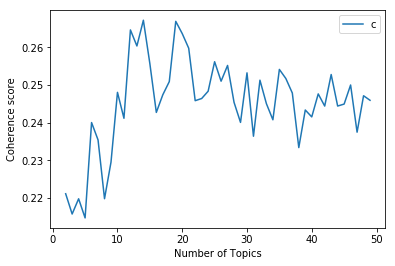

In [20]:
print "determining the number of topics"
def tokenize_titles(titles):

    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    texts = []
    for title in titles:
        raw = title.decode('utf-8').strip().lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [token for token in tokens if not token in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    return texts

words = tokenize_titles(sampled_titles)
dictionary = corpora.Dictionary(words)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in words]
def compute_plot_coherence_values(doc_term_matrix, stop, start=2, step=1):

    coherence_values = []
    model_list = []
    num_options = range(start, stop, step)
    for num_topics in num_options:
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=words, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    print "coherence scores: {}".format(coherence_values)
    print "plotting coherence score for different number of topics" 
    plt.plot(num_options, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence scores"), loc='best')
    plt.show()

compute_plot_coherence_values(doc_term_matrix, 50, 2, 1)

In [2]:
print "setting num of topics to be 14"
n_topics = 14
lsa_model = Topic_Model(df, model_type='LSA', max_features=40000, n_components=n_topics)
lsa_model.get_top_n_topics(count_vectorizer_limited, 10)

setting num of topics to be 14
initialing & fitting LSA model...
Model initialization done. Model saved to disk.
top 10 words for each topic by LSA:
('Topic 1: ', u'uk says year syrian war years said military isis chinese')
('Topic 2: ', u'china sea south chinese japan world korea new india beijing')
('Topic 3: ', u'korea north south korean kim jong nuclear africa missile new')
('Topic 4: ', u'new zealand law york government year president world report israel')
('Topic 5: ', u'says russia iran new ukraine president minister official uk report')
('Topic 6: ', u'russia syria ukraine russian putin military rebels chemical turkey weapons')
('Topic 7: ', u'police ukraine putin eu russian russia protesters officers news uk')
('Topic 8: ', u'iran nuclear deal israel plant talks japan fukushima israeli netanyahu')
('Topic 9: ', u'world news bbc cup war global climate largest people says')
('Topic 10: ', u'government minister prime country said election venezuela opposition state anti')
('Topic

initialing & fitting LSA model...
generating categories...
keys done
categories
self.categories:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
top_3_words:[u'says attack syrian', u'china sea south', u'new zealand government', u'says korea north', u'korea north south', u'syria iran nuclear', u'iran police nuclear', u'world news bbc', u'russia ukraine russian', u'president obama venezuela', u'israel gaza israeli', u'state killed islamic', u'government uk war', u'people year 000']
Frequency of the 14 topics by LSA:


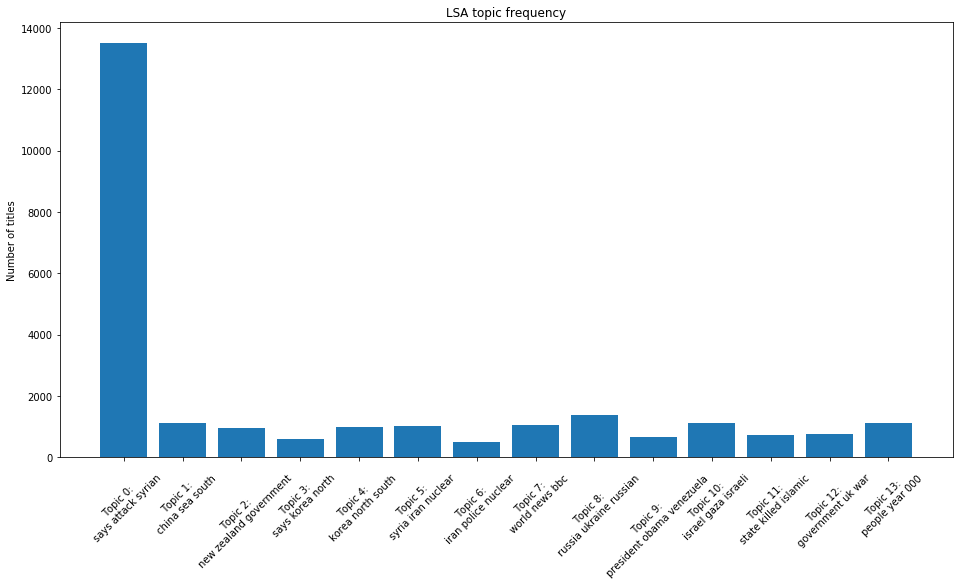

In [5]:
lsa_model = Topic_Model(df, model_type='LSA', max_features=40000, n_components=14)
lsa_model.plot_num_title_of_each_topic(count_vectorizer_limited)

initialing & fitting LSA model...
generating categories...
keys done
categories
use t-SNE to visualize LSA high dimensional dataset


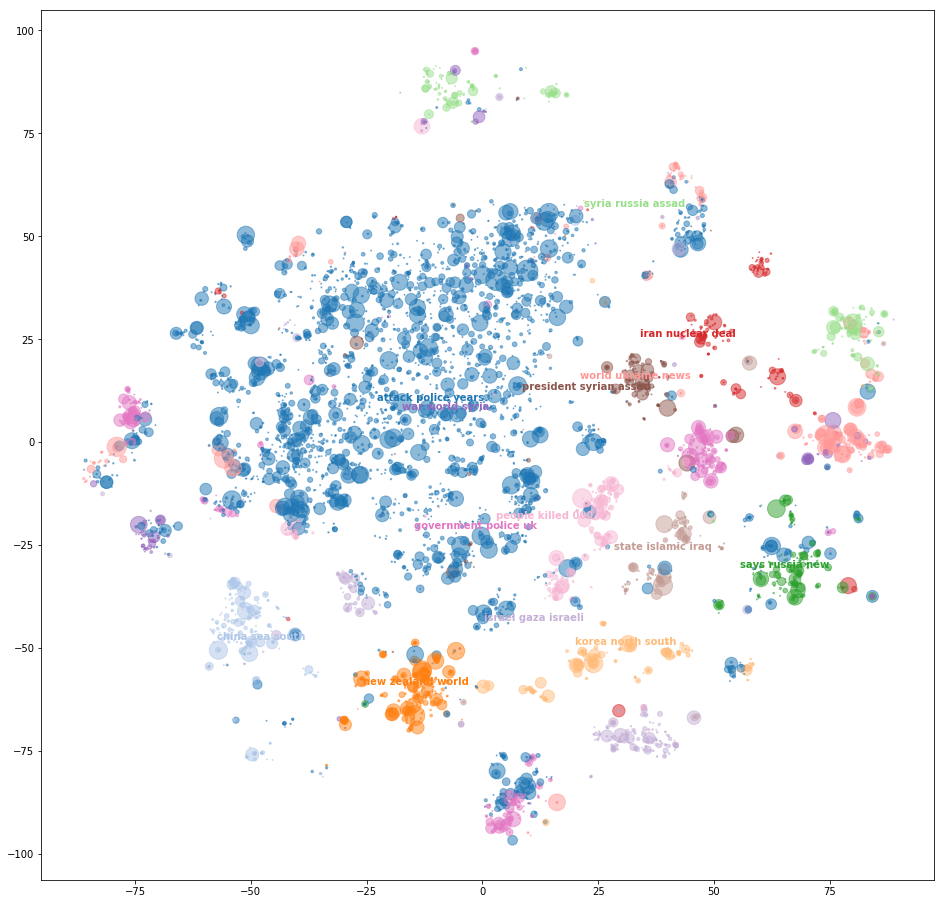

In [4]:
lsa_model = Topic_Model(df, model_type='LSA', max_features=40000, n_components=14)
lsa_model.visualize_tnse_2_dimension(count_vectorizer_limited)

In [24]:
print "Try LDA"
lda_model = Topic_Model(df, model_type='LDA', max_features=40000, learning_method='online', n_components=14, random_state=0, verbose=0)
lda_model.get_top_n_topics(count_vectorizer_limited, 10)

Try LDA
initialing & fitting LDA model...
Model initialization done. Model saved to disk.
top 10 words for each topic by LDA:
('Topic 1: ', u'israel israeli gaza year palestinian 000 bank old report says')
('Topic 2: ', u'death iran obama president france says military air world calls')
('Topic 3: ', u'court snowden european states united asylum says 000 uk china')
('Topic 4: ', u'syria al syrian state isis forces islamic russia iraq attack')
('Topic 5: ', u'ukraine putin russia crisis germany power president says vote russian')
('Topic 6: ', u'saudi says arabia police attacks man climate change china arrested')
('Topic 7: ', u'rights human law anti eu rebels sex new israel syrian')
('Topic 8: ', u'news iran bbc egypt nuclear british eu china warns terror')
('Topic 9: ', u'russia nuclear says new russian japan china talks world global')
('Topic 10: ', u'world years women ebola new australian china health says ship')
('Topic 11: ', u'china new world government south deal sea says intern

initialing & fitting LDA model...
model initialization done.
self.categories:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
top_3_words:[u'saudi police pakistan', u'government new 000', u'oil minister china', u'say president children', u'nuclear power climate', u'russian ukraine russia', u'israel killed says', u'iran says syria', u'china police japan', u'korea north new', u'syria russia al', u'news bbc dead', u'china says sex', u'state islamic egypt']
Frequency of the 14 topics by LDA:


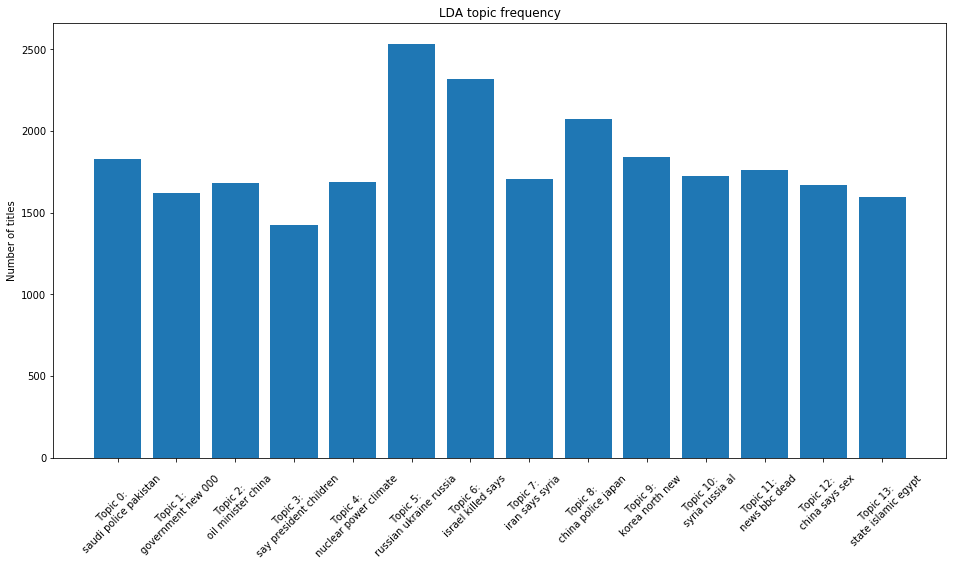

In [8]:
lda_model = Topic_Model(df, model_type='LDA', max_features=40000, learning_method='online', n_components=14, random_state=0, verbose=0)
lda_model.plot_num_title_of_each_topic(count_vectorizer_limited)

initialing & fitting LDA model...
Model initialization done. Model saved to disk.
use t-SNE to visualize LDA high dimensional dataset


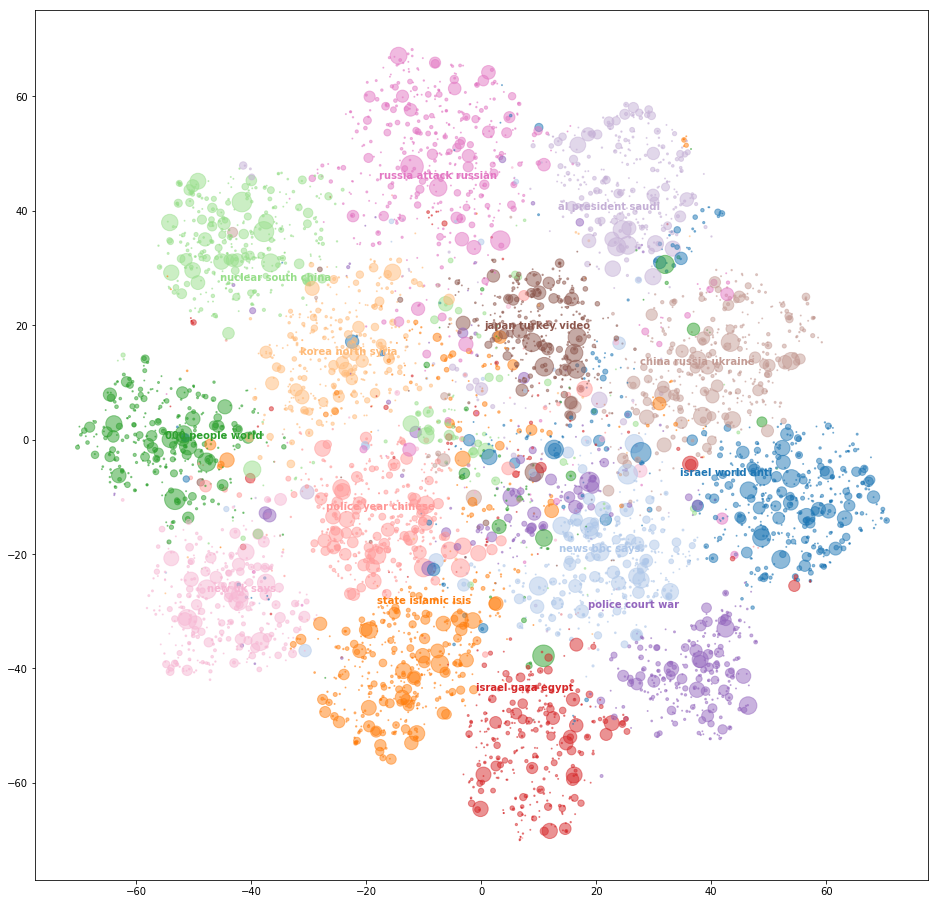

In [3]:
lda_model = Topic_Model(df, model_type='LDA', max_features=40000, learning_method='online', n_components=14, random_state=0, verbose=0)
lda_model.visualize_tnse_2_dimension(count_vectorizer_limited)

In [8]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model.model, lda_model.sampled_document_term_matrix, count_vectorizer_limited, mds='tsne')

PreparedData(topic_coordinates=           Freq  cluster  topics           x           y
topic                                                   
0      9.327435        1       1  -71.726349  -82.997742
2      8.629929        1       2 -261.324554  170.552216
12     8.397478        1       3  242.983551 -117.788933
6      7.458165        1       4  210.244568  223.178986
8      7.421778        1       5 -228.588760 -170.437653
11     7.416793        1       6   74.344757  -21.384562
7      7.308206        1       7   88.718224 -194.881561
5      7.215714        1       8   49.139938  315.299713
4      6.823618        1       9  -92.725090   74.141335
3      6.424204        1      10  231.145844   54.255299
1      6.368416        1      11  -67.471741 -262.544495
9      6.114164        1      12   53.351151  135.755417
13     5.939739        1      13 -107.061523  247.654053
10     5.154360        1      14 -249.538132   -1.507141, topic_info=      Category         Freq       Term        Total  loglift  logprob
21742  Default   895.000000      syria   895.000000  30.0000  30.0000
4514   Default  1317.000000      china  1317.000000  29.0000  29.0000
14993  Default  1026.000000        new  1026.000000  28.0000  28.0000
17015  Default   689.000000  president   689.000000  27.0000  27.0000
12329  Default   670.000000     killed   670.000000  26.0000  26.0000
19066  Default   903.000000     russia   903.000000  25.0000  25.0000
22916  Default   586.000000         uk   586.000000  24.0000  24.0000
20674  Default   592.000000      south   592.000000  23.0000  23.0000
15002  Default   561.000000       news   561.000000  22.0000  22.0000
16704  Default   762.000000     police   762.000000  21.0000  21.0000
11771  Default   738.000000     israel   738.000000  20.0000  20.0000
20996  Default   619.000000      state   619.000000  19.0000  19.0000
19355  Default  1220.000000       says  1220.000000  18.0000  18.0000
12438  Default   517.000000      korea   517.000000  17.0000  17.0000
15166  Default   505.000000      north   505.000000  16.0000  16.0000
21743  Default   481.000000     syrian   481.000000  15.0000  15.0000
15248  Default   478.000000    nuclear   478.000000  14.0000  14.0000
16238  Default   596.000000     people   596.000000  13.0000  13.0000
22820  Default   404.000000     turkey   404.000000  12.0000  12.0000
22918  Default   451.000000    ukraine   451.000000  11.0000  11.0000
11737  Default   467.000000       isis   467.000000  10.0000  10.0000
11865  Default   377.000000      japan   377.000000   9.0000   9.0000
7962   Default   428.000000         eu   428.000000   8.0000   8.0000
19067  Default   579.000000    russian   579.000000   7.0000   7.0000
19324  Default   388.000000      saudi   388.000000   6.0000   6.0000
1      Default   490.000000        000   490.000000   5.0000   5.0000
24396  Default   518.000000       year   518.000000   4.0000   4.0000
14168  Default   529.000000   minister   529.000000   3.0000   3.0000
5575   Default   415.000000      court   415.000000   2.0000   2.0000
11691  Default   717.000000       iran   717.000000   1.0000   1.0000
...        ...          ...        ...          ...      ...      ...
10384  Topic14   146.623379       held   147.469387   2.9596  -4.4642
11185  Topic14   125.274967  including   126.120977   2.9586  -4.6215
12630  Topic14   124.037686    largest   124.883693   2.9585  -4.6315
1042   Topic14   117.446828  activists   118.292835   2.9581  -4.6861
14385  Topic14   110.272634      money   111.118641   2.9577  -4.7491
12779  Topic14   108.258770       left   109.104778   2.9575  -4.7675
23916  Topic14   105.714040        way   106.560047   2.9574  -4.7913
10748  Topic14   105.200036      house   106.046043   2.9573  -4.7962
2000   Topic14   100.822675    arrests   101.668682   2.9570  -4.8387
2607   Topic14    89.177105       bans    90.023111   2.9559  -4.9614
2380   Topic14    88.938020       away    89.784028   2.9559  -4.9641
8552   Topic14    81.355519     fem

In [3]:
print("Scale up to the entire dataset")
print("lazy loading dataset...")
entire_df = df
entire_titles = entire_df['title'].compute().values
entire_up_votes = entire_df['up_votes'].compute().values
print("Done.")

Scale up to the entire dataset
lazy loading dataset...
Done.


initializing LDA model...
initialing & fitting LDA model...
generating categories...
keys done
categories
use t-SNE to visualize LDA high dimensional dataset
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 76385 samples in 0.115s...
[t-SNE] Computed neighbors for 76385 samples in 220.357s...
[t-SNE] Computed conditional probabilities for sample 1000 / 76385
[t-SNE] Computed conditional probabilities for sample 2000 / 76385
[t-SNE] Computed conditional probabilities for sample 3000 / 76385
[t-SNE] Computed conditional probabilities for sample 4000 / 76385
[t-SNE] Computed conditional probabilities for sample 5000 / 76385
[t-SNE] Computed conditional probabilities for sample 6000 / 76385
[t-SNE] Computed conditional probabilities for sample 7000 / 76385
[t-SNE] Computed conditional probabilities for sample 8000 / 76385
[t-SNE] Computed conditional probabilities for sample 9000 / 76385
[t-SNE] Computed conditional probabilities for sample 10000 / 76385
[t-SNE] Computed conditio

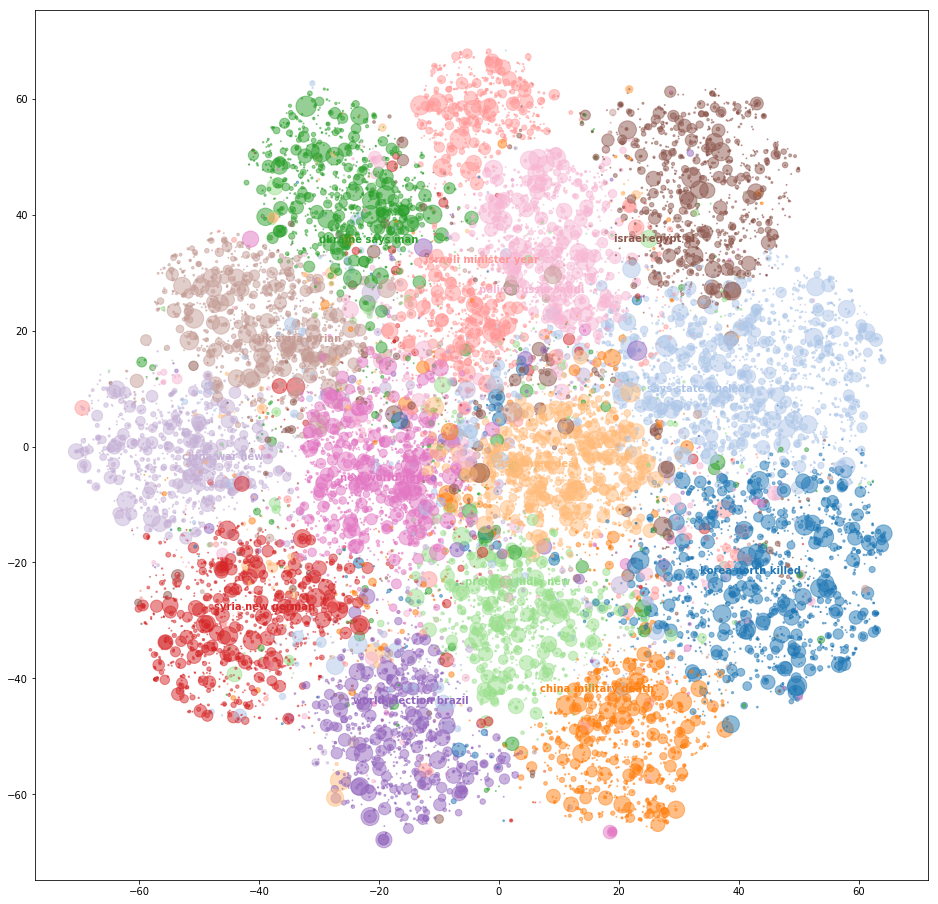

In [4]:
print "initializing LDA model..."
entire_lda_model = Topic_Model(entire_df, sample_rate=0.15, model_type='LDA', max_features=100000, learning_method='online', n_components=14, random_state=0, verbose=0)
entire_lda_model.visualize_tnse_2_dimension(count_vectorizer_limited)

In [4]:
entire_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
print("count_vectorizer initialized")
entire_document_term_matrix = entire_count_vectorizer.fit_transform(entire_titles)
print("entire_document_term_matrix initialized")
entire_lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=0, verbose=1)
print("LDA model initialized")
entire_lda_model.fit(entire_document_term_matrix);
print("training on the entire dataset done.")

count_vectorizer initialized
entire_document_term_matrix initialized
LDA model initialized
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
training on the entire dataset done.


In [7]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(entire_lda_model, entire_document_term_matrix, entire_count_vectorizer, mds='tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
6      11.715188        1       1  -85.570625  -52.882725
4      10.850917        1       2   95.804527    6.254715
7      10.740819        1       3   52.436348  -55.039932
8      10.647637        1       4   -1.858447   -9.281190
5      10.275914        1       5  -63.979553   29.604427
2       9.621924        1       6  -14.350033  -79.307159
9       9.429399        1       7  116.622017  -88.197159
0       9.361252        1       8  -49.560940 -142.233215
3       8.865648        1       9   41.888268 -137.961319
1       8.491301        1      10   28.827253   57.622002, topic_info=      Category          Freq           Term         Total  loglift  logprob
7445   Default  28939.000000          china  28939.000000  30.0000  30.0000
31586  Default  28527.000000           says  28527.000000  29.0000  29.0000
35284  Default  19470.000000          syria  19470.000000  28.0000  28.0000
27350  Default  16925.000000         police  16925.000000  27.0000  27.0000
39353  Default  17403.000000          world  17403.000000  26.0000  26.0000
3647   Default  14611.000000         attack  14611.000000  25.0000  25.0000
24650  Default  22713.000000            new  22713.000000  24.0000  24.0000
27842  Default  15380.000000      president  15380.000000  23.0000  23.0000
19147  Default  13930.000000         israel  13930.000000  22.0000  22.0000
31135  Default  13830.000000        russian  13830.000000  21.0000  21.0000
19000  Default  13868.000000           iran  13868.000000  20.0000  20.0000
19094  Default  13611.000000           isis  13611.000000  19.0000  19.0000
18252  Default  12363.000000          india  12363.000000  18.0000  18.0000
34113  Default  16223.000000          state  16223.000000  17.0000  17.0000
31134  Default  21056.000000         russia  21056.000000  16.0000  16.0000
38673  Default  11538.000000            war  11538.000000  15.0000  15.0000
20339  Default  11567.000000          korea  11567.000000  14.0000  14.0000
20118  Default  15193.000000         killed  15193.000000  13.0000  13.0000
24949  Default  11242.000000          north  11242.000000  12.0000  12.0000
31283  Default  11065.000000           said  11065.000000  11.0000  11.0000
39618  Default  11270.000000           year  11270.000000  10.0000  10.0000
23231  Default  11180.000000       minister  11180.000000   9.0000   9.0000
19103  Default   9792.000000        islamic   9792.000000   8.0000   8.0000
24668  Default  10632.000000           news  10632.000000   7.0000   7.0000
1      Default  10644.000000            000  10644.000000   6.0000   6.0000
15792  Default  14983.000000     government  14983.000000   5.0000   5.0000
35286  Default  10284.000000         syrian  10284.000000   4.0000   4.0000
33570  Default  12552.000000          south  12552.000000   3.0000   3.0000
37007  Default  11233.000000         turkey  11233.000000   2.0000   2.0000
39623  Default   9276.000000          years   9276.000000   1.0000   1.0000
...        ...           ...            ...           ...      ...      ...
4532   Topic10   5942.090522            bbc   5942.980011   2.4660  -4.2421
18787  Topic10   5560.146344  international   5561.035872   2.4660  -4.3085
3310   Topic10   5351.089257       arrested   5351.978755   2.4660  -4.3468
28259  Topic10   5237.063882        protest   5237.953357   2.4660  -4.3684
18253  Topic10   5055.582422         indian   5056.471898   2.4660  -4.4036
38716  Topic10   4856.516457          warns   4857.405959   2.4659  -4.4438
32212  Topic10   4485.572337            set   4486.461860   2.4659  -4.5233
38489  Topic10   4417.070003           vote   4417.959509   2.4659  -4.5386
2158   Topic10   4161.813177         africa   4162.702638   2.4659  -4.5982
11955  Topic10   3997.111856           east   3998.001323   2.4659  -4.6385
6826   Topic10   3799.704045           case   3800.593546   2.4659  -

In [10]:
years = df['date_created'].dt.year.compute()
start_year, end_year = min(years), max(years)
yearly_topics = {}
for year in range(start_year, end_year + 1):
    print "tackling {} topics...".format(year)
    yearly_ds = df[df['date_created'].dt.year == year]
    yearly_ds_titles = yearly_ds['title'].compute().values
    count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
    document_term_matrix = count_vectorizer.fit_transform(yearly_ds_titles)
    lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', verbose=0)
    topic_matrix = lda_model.fit_transform(document_term_matrix)
    keys = get_keys(topic_matrix)
    categories, counts = keys_to_counts(keys)
    top_n_words = get_top_n_words(1, 10, document_term_matrix, keys, count_vectorizer)
    yearly_topics[year] = top_n_words
for key in sorted(yearly_topics.keys()):
    print "{} top 10 topic words: {}".format(key, yearly_topics[key])

tackling 2008 topics...
tackling 2009 topics...
tackling 2010 topics...
tackling 2011 topics...
tackling 2012 topics...
tackling 2013 topics...
tackling 2014 topics...
tackling 2015 topics...
tackling 2016 topics...
2008 top 10 topic words: [u'death', u'000', u'uk', u'police', u'pakistan', u'israel', u'world', u'iran', u'war', u'china']
2009 top 10 topic words: [u'israel', u'afghanistan', u'iran', u'pirates', u'pakistan', u'gaza', u'war', u'flu', u'korea', u'obama']
2010 top 10 topic words: [u'war', u'haiti', u'assange', u'israel', u'israel', u'afghanistan', u'police', u'iran', u'wikileaks', u'china']
2011 top 10 topic words: [u'news', u'police', u'mexico', u'rights', u'nuclear', u'new', u'al', u'libya', u'syria', u'libyan']
2012 top 10 topic words: [u'israel', u'syria', u'world', u'nuclear', u'government', u'syrian', u'news', u'china', u'iran', u'china']
2013 top 10 topic words: [u'police', u'news', u'egypt', u'iran', u'india', u'year', u'syria', u'syria', u'minister', u'korea']
2014 